# Import dataset

In [1]:
# Import libraries

import os
import random
import shutil
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
# Set seed for reproducibility

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Load the dataset 

dataset_dir = '../input/training-dataset-homework1zip/training_data_final'

labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7


# Metadata

epochs = 200
batch_size= 16
input_shape = (96, 96, 3)

In [4]:
# Cutout function - implementation taken from https://github.com/yu4u/cutout-random-erasing

"""
p : the probability that random erasing is performed
s_l, s_h : minimum / maximum proportion of erased area against input image
r_1, r_2 : minimum / maximum aspect ratio of erased area
v_l, v_h : minimum / maximum value for erased area
pixel_level : pixel-level randomization for erased area
"""

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape
        
        
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [5]:
# Generate a training set of example to show augmented image samples

show_data_gen = ImageDataGenerator(validation_split=0.1,
                                   horizontal_flip = True,
                                   fill_mode = "reflect",
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   brightness_range = (0.7,1.3),
                                   preprocessing_function=get_random_eraser(
                                       p=0.3, s_l=0.02, s_h=0.1, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1) #apply cutout
                                   )

show_data_gen = show_data_gen.flow_from_directory(directory=dataset_dir, 
                                               target_size=(96, 96), 
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=1, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed,
                                               subset = 'training')


# Generate a copy of the validation set to perform some checks at the and of the fit operation

show_validation = ImageDataGenerator(validation_split=0.1)

show_validation = show_validation.flow_from_directory(directory=dataset_dir, 
                                           target_size=(96, 96), 
                                           color_mode='rgb',
                                           classes=None,
                                           batch_size=1, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=seed,
                                           subset = 'validation')

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


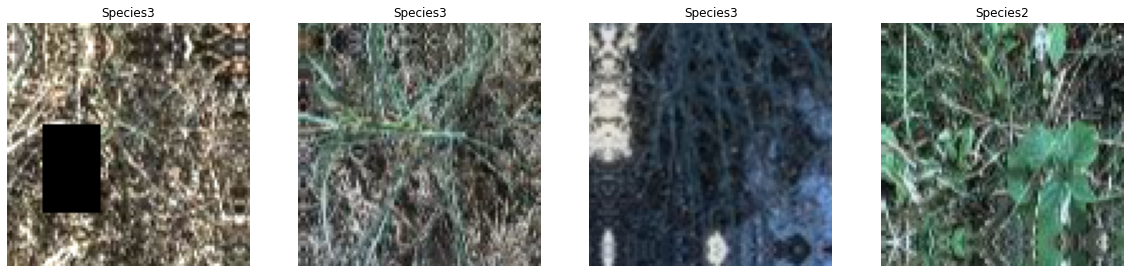

In [6]:
# Plot augmented image samples

nrows=1
ncols=4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

for i in range(nrows*ncols):
    # convert to unsigned integers for plotting
    image, label = next(show_data_gen)
    image = image[0].astype('uint8')

    # changing size from (1, _, _, 3) to (_, _, 3) for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].set_title(labels[np.argmax(label[0])])
    ax[i].axis('off')

In [7]:
# Create an instance of ImageDataGenerator for training and validation sets

train_data_gen = ImageDataGenerator(validation_split=0.1,
                                    horizontal_flip = True,
                                    fill_mode = "reflect",
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    brightness_range = (0.7,1.3),
                                    preprocessing_function=get_random_eraser(
                                        p=0.3, s_l=0.02, s_h=0.1, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1) #apply cutout
                                   
                                   )

valid_data_gen = ImageDataGenerator(validation_split=0.1)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_data_gen = train_data_gen.flow_from_directory(directory=dataset_dir, 
                                               target_size=(96, 96), 
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed,
                                               subset = 'training')

valid_data_gen = valid_data_gen.flow_from_directory(directory=dataset_dir, 
                                           target_size=(96, 96), 
                                           color_mode='rgb',
                                           classes=None,
                                           batch_size=batch_size, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=seed,
                                           subset = 'validation')

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [8]:
# Assess some data

print("Assigned labels")
print(train_data_gen.class_indices)
print()
print("Target classes")
print(train_data_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [9]:
# Define weights for class imbalance

total = 3542
n_classes = 8.0

weight_for_s1 = (1 / 186) * (total / n_classes)
weight_for_s2 = (1 / 532) * (total / n_classes)
weight_for_s3 = (1 / 515) * (total / n_classes)
weight_for_s4 = (1 / 511) * (total / n_classes)
weight_for_s5 = (1 / 531) * (total / n_classes)
weight_for_s6 = (1 / 222) * (total / n_classes)
weight_for_s7 = (1 / 537) * (total / n_classes)
weight_for_s8 = (1 / 508) * (total / n_classes)

class_weight = {0: weight_for_s1, 1: weight_for_s2, 2: weight_for_s3, 3: weight_for_s4,
                4: weight_for_s5, 5: weight_for_s6, 6: weight_for_s7, 7: weight_for_s8}

print('Weight for class 1: {:.2f}'.format(weight_for_s1))
print('Weight for class 2: {:.2f}'.format(weight_for_s2))
print('Weight for class 3: {:.2f}'.format(weight_for_s3))
print('Weight for class 4: {:.2f}'.format(weight_for_s4))
print('Weight for class 5: {:.2f}'.format(weight_for_s5))
print('Weight for class 6: {:.2f}'.format(weight_for_s6))
print('Weight for class 7: {:.2f}'.format(weight_for_s7))
print('Weight for class 8: {:.2f}'.format(weight_for_s8))

Weight for class 1: 2.38
Weight for class 2: 0.83
Weight for class 3: 0.86
Weight for class 4: 0.87
Weight for class 5: 0.83
Weight for class 6: 1.99
Weight for class 7: 0.82
Weight for class 8: 0.87


# Transfer learning

In [10]:
# Import EfficientNetB2

supernet = tfk.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_shape=(192,192,3)
)
supernet.summary()
#tfk.utils.plot_model(supernet)

2022-11-26 18:55:42.547640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:55:42.657800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:55:42.658637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:55:42.660194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

31801344/31790344 [==============================] - 2s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 192, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 192, 192, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 193, 193, 3)  0           normalization[0][0]              
____________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
Preprocessing (Lambda)       (None, 96, 96, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 6, 6, 1408)        7768569   
_________________________________________________________________
Gap (GlobalAveragePooling2D) (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
Classifier (Dense)           (None, 256)               360704

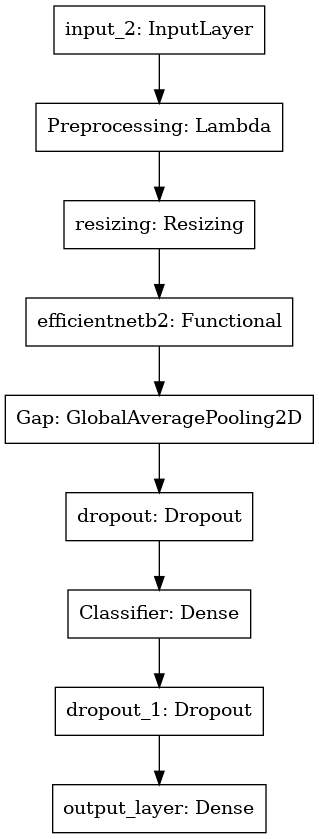

In [11]:
# Use the supernet as feature extractor -> to keep fixed the value of weight

supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                           input_shape=(96, 96, 3), name='Preprocessing')(inputs) #preprocess according to EfficientNetB2
x = tfkl.Resizing(192, 192, interpolation="bicubic")(x)
x = supernet(x)
gap_layer = tfkl.GlobalAveragePooling2D(name='Gap')(x)
dropout = tfkl.Dropout(0.35, seed=seed)(gap_layer)
classifier_layer = tfkl.Dense(units=256, name='Classifier', 
                              kernel_initializer=tfk.initializers.HeUniform(seed), 
                              activation='relu'
                              )(dropout)

dropout = tfkl.Dropout(0.35, seed=seed)(classifier_layer)
output_layer = tfkl.Dense(units=8, activation='softmax', 
                              kernel_initializer=tfk.initializers.HeUniform(seed), 
                              name='output_layer'
                              )(dropout)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

model.summary()
tfk.utils.plot_model(model)

In [12]:
# Train the model

history = model.fit(
    train_data_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_data_gen,
    class_weight = class_weight,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                mode='max', 
                                                patience=10, 
                                                restore_best_weights=True)
).history

2022-11-26 18:55:51.402763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-11-26 18:55:59.453056: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 39s 129ms/step - loss: 1.4458 - accuracy: 0.4641 - val_loss: 1.0253 - val_accuracy: 0.5926
Epoch 2/200
200/200 [==============================] - 15s 74ms/step - loss: 1.1572 - accuracy: 0.5807 - val_loss: 0.9161 - val_accuracy: 0.6496
Epoch 3/200
200/200 [==============================] - 15s 77ms/step - loss: 1.0619 - accuracy: 0.6186 - val_loss: 0.8793 - val_accuracy: 0.6610
Epoch 4/200
200/200 [==============================] - 15s 74ms/step - loss: 1.0124 - accuracy: 0.6255 - val_loss: 0.7772 - val_accuracy: 0.7151
Epoch 5/200
200/200 [==============================] - 16s 78ms/step - loss: 0.9684 - accuracy: 0.6453 - val_loss: 0.7985 - val_accuracy: 0.6980
Epoch 6/200
200/200 [==============================] - 15s 75ms/step - loss: 0.9622 - accuracy: 0.6537 - val_loss: 0.7678 - val_accuracy: 0.7151
Epoch 7/200
200/200 [==============================] - 16s 80ms/step - loss: 0.9113 - accuracy: 0.6688 - val_loss: 0.7170 - val_accuracy: 0.7

In [13]:
# Save best epoch model

model.save("SubmissionModel")

2022-11-26 19:07:30.440011: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
# Make a zip to download the model

shutil.make_archive("SubmissionModel", 'zip', "./SubmissionModel")

'/kaggle/working/SubmissionModel.zip'

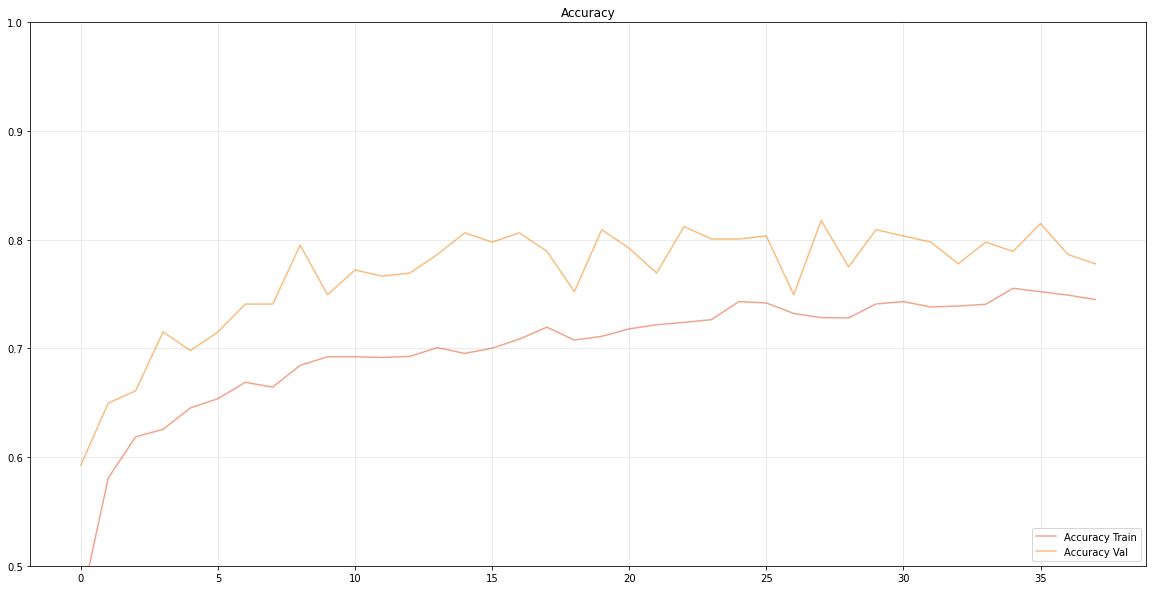

In [15]:
# Plot accuracy graph

plt.figure(figsize=(20,10))

ALPHA = 0.5
 
plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19') 
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00') 
 
plt.ylim(.5, 1) 
plt.title('Accuracy') 
plt.legend(loc='lower right') 
plt.grid(alpha=.3) 
plt.show()

Accuracy: 0.8177
Precision: 0.7978
Recall: 0.8126
F1: 0.8024


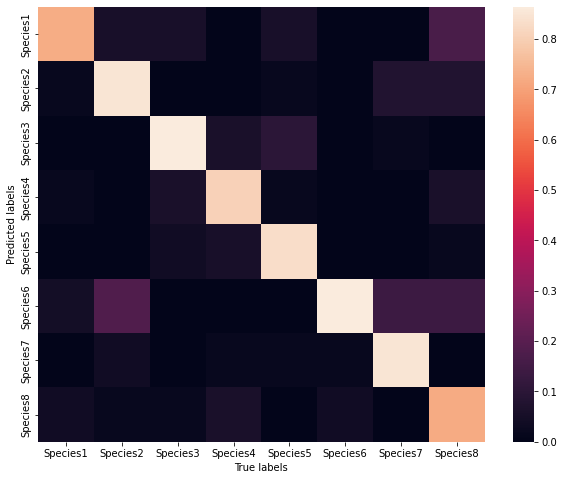

In [16]:
# Plot confusion matrix

# Predict the validation set
y_val = valid_data_gen.labels
predictions = model.predict(valid_data_gen)
predictions.shape

labels = {0:'Species1',       # 0
          1:'Species2',       # 1
          2:'Species3',       # 2
          3:'Species4',       # 3
          4:'Species5',       # 4
          5:'Species6',       # 5
          6:'Species7',       # 6
          7:'Species8'}       # 7

# Compute the confusion matrix
cm = confusion_matrix(y_val, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(y_val, np.argmax(predictions, axis=-1))
precision = precision_score(y_val, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_val, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_val, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

cm = cm /cm.astype(float).sum(axis=1);

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [17]:
# Print some statistics

print( classification_report(y_val, np.argmax(predictions, axis=-1)) )

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.82      0.85      0.83        53
           2       0.83      0.86      0.85        51
           3       0.84      0.80      0.82        51
           4       0.88      0.83      0.85        53
           5       0.63      0.86      0.73        22
           6       0.90      0.85      0.87        53
           7       0.80      0.72      0.76        50

    accuracy                           0.82       351
   macro avg       0.80      0.81      0.80       351
weighted avg       0.82      0.82      0.82       351



# Fine tuning

In [18]:
# Re-load the model after transfer learning

model = tfk.models.load_model("SubmissionModel")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
Preprocessing (Lambda)       (None, 96, 96, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 6, 6, 1408)        7768569   
_________________________________________________________________
Gap (GlobalAveragePooling2D) (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
Classifier (Dense)           (None, 256)               360704

In [19]:
# Set all layers to be trainable

model.get_layer('efficientnetb2').trainable = True
for i, layer in enumerate(model.get_layer('efficientnetb2').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block1b_dwconv True
18 block1b_bn True
19 block1b_activation True
20 block1b_se_squeeze True
21 block1b_se_reshape True
22 block1b_se_reduce True
23 block1b_se_expand True
24 block1b_se_excite True
25 block1b_project_conv True
26 block1b_project_bn True
27 block1b_drop True
28 block1b_add True
29 block2a_expand_conv True
30 block2a_expand_bn True
31 block2a_expand_activation True
32 block2a_dwconv_pad True
33 block2a_dwconv True
34 block2a_bn True
35 block2a_activation True
36 block2a_se_squeeze True
37 block2a_se_reshape True
38 block2a_se_reduce True
39 block2a_se_expand True
40 block2a_se_excite True
41 

In [20]:
# Decide which layer set to false (first N ones)

N = 0
for i, layer in enumerate(model.get_layer('efficientnetb2').layers[:N]):
    layer.trainable=False
for i, layer in enumerate(model.get_layer('efficientnetb2').layers):
    print(i, layer.name, layer.trainable)
model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block1b_dwconv True
18 block1b_bn True
19 block1b_activation True
20 block1b_se_squeeze True
21 block1b_se_reshape True
22 block1b_se_reduce True
23 block1b_se_expand True
24 block1b_se_excite True
25 block1b_project_conv True
26 block1b_project_bn True
27 block1b_drop True
28 block1b_add True
29 block2a_expand_conv True
30 block2a_expand_bn True
31 block2a_expand_activation True
32 block2a_dwconv_pad True
33 block2a_dwconv True
34 block2a_bn True
35 block2a_activation True
36 block2a_se_squeeze True
37 block2a_se_reshape True
38 block2a_se_reduce True
39 block2a_se_expand True
40 block2a_se_excite True
41 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
Preprocessing (Lambda)       (None, 96, 96, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 6, 6, 1408)        7768569   
_________________________________________________________________
Gap (GlobalAveragePooling2D) (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
Classifier (Dense)           (None, 256)               360704

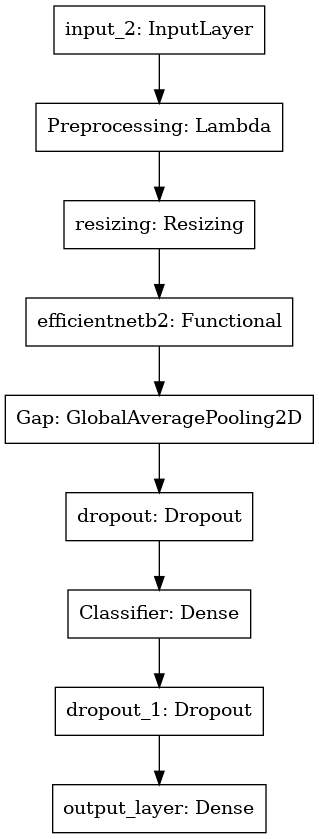

In [21]:
# Compile the model

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.0001), metrics='accuracy')

model.summary()
tfk.utils.plot_model(model)

In [22]:
# Train the model

history = model.fit(
    train_data_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_data_gen,
    class_weight = class_weight,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                mode='max', 
                                                patience=10, 
                                                restore_best_weights=True)
).history

Epoch 1/200
200/200 [==============================] - 51s 187ms/step - loss: 2.1767 - accuracy: 0.4281 - val_loss: 1.1399 - val_accuracy: 0.6068
Epoch 2/200
200/200 [==============================] - 35s 172ms/step - loss: 1.1911 - accuracy: 0.5804 - val_loss: 0.9015 - val_accuracy: 0.6439
Epoch 3/200
200/200 [==============================] - 35s 173ms/step - loss: 0.9946 - accuracy: 0.6440 - val_loss: 0.7722 - val_accuracy: 0.7123
Epoch 4/200
200/200 [==============================] - 35s 172ms/step - loss: 0.8766 - accuracy: 0.6910 - val_loss: 0.6291 - val_accuracy: 0.7721
Epoch 5/200
200/200 [==============================] - 35s 174ms/step - loss: 0.7283 - accuracy: 0.7377 - val_loss: 0.6108 - val_accuracy: 0.8091
Epoch 6/200
200/200 [==============================] - 35s 172ms/step - loss: 0.6804 - accuracy: 0.7643 - val_loss: 0.5586 - val_accuracy: 0.8205
Epoch 7/200
200/200 [==============================] - 34s 172ms/step - loss: 0.5810 - accuracy: 0.7863 - val_loss: 0.4765 -

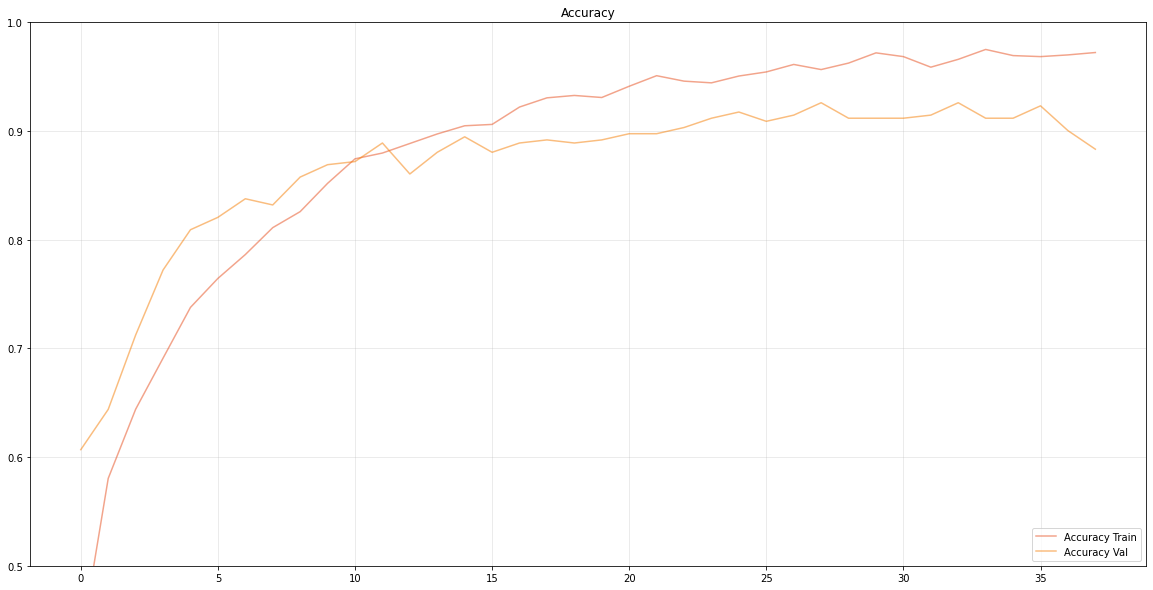

In [23]:
# Plot accuracy graph

plt.figure(figsize=(20,10))

ALPHA = 0.5
 
plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19') 
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00') 
 
plt.ylim(.5, 1) 
plt.title('Accuracy') 
plt.legend(loc='lower right') 
plt.grid(alpha=.3) 
plt.show()

Accuracy: 0.9259
Precision: 0.9156
Recall: 0.9215
F1: 0.9176


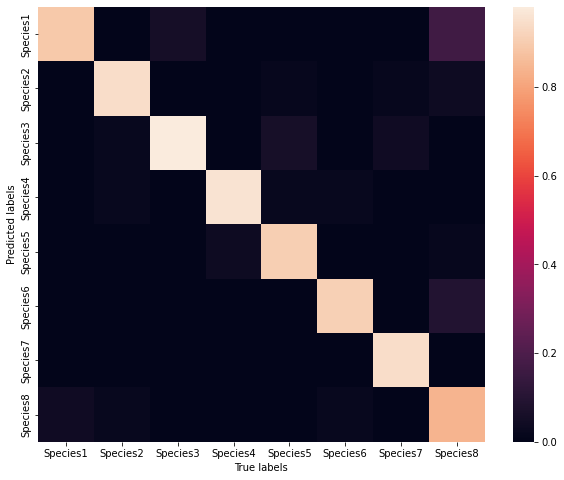

In [24]:
# Plot confusion matrix

# Predict the validation set
y_val = valid_data_gen.labels
predictions = model.predict(valid_data_gen)
predictions.shape

labels = {0:'Species1',       # 0
          1:'Species2',       # 1
          2:'Species3',       # 2
          3:'Species4',       # 3
          4:'Species5',       # 4
          5:'Species6',       # 5
          6:'Species7',       # 6
          7:'Species8'}       # 7

# Compute the confusion matrix
cm = confusion_matrix(y_val, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(y_val, np.argmax(predictions, axis=-1))
precision = precision_score(y_val, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_val, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_val, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

cm = cm /cm.astype(float).sum(axis=1);

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [25]:
# Print some statistics

print( classification_report(y_val, np.argmax(predictions, axis=-1)) )

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.93      0.94      0.93        53
           2       0.89      0.98      0.93        51
           3       0.94      0.96      0.95        51
           4       0.94      0.91      0.92        53
           5       0.91      0.91      0.91        22
           6       1.00      0.94      0.97        53
           7       0.91      0.84      0.87        50

    accuracy                           0.93       351
   macro avg       0.92      0.92      0.92       351
weighted avg       0.93      0.93      0.93       351



In [26]:
# Save best epoch model

model.save("SubmissionModelFT")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
# Make a zip to download the model

shutil.make_archive("SubmissionModelFT", 'zip', "./SubmissionModelFT")

'/kaggle/working/SubmissionModelFT.zip'

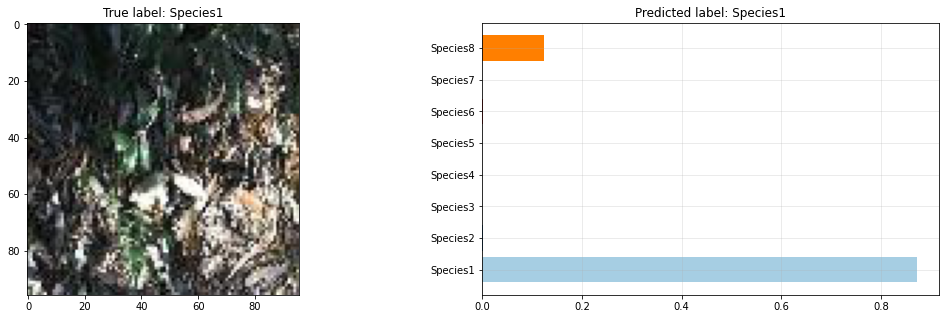

In [29]:
# Plot the target images and the predictions
prediction_index = 14

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
show_validation.reset() #to restart the counter
for i in range (0, prediction_index):
    _,_ = next(show_validation) #to go till the desired image
image, label = next(show_validation)
image = image[0].astype('uint8')
ax1.imshow(np.squeeze(image))
ax1.set_title('True label: '+labels[np.argmax(label[0])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()